In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import seaborn as sns

import scipy as sp
from scipy import sparse
import sklearn
import umap

## add your packages ##

import time
import pickle
import memory_profiler
from collections import Counter
import matplotlib.colors as mcolors

%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../datX")

In [4]:
plt.style.use("matplotlib_style.txt")

In [5]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [6]:
# META DATA

meta = pd.read_csv("data/m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [7]:
# READ COUNTS

data_exons = pd.read_csv(
    "data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [8]:
data_exons

20171204_sample_2  20171204_sample_4  20171204_sample_5  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                  0                 68               1291   
0610009E02Rik                  0                  0                  0   
0610009L18Rik                  0                  0                  0   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171204_sample_6  20171207_sample_1  20171207_sample_2  \
0610005C13Rik                  0                  0                  1   
0610006L08Rik                  0                  0                 13   
0610009B22Rik                  0                  0                  0   
0610009E02Rik                  0                 30                 80   
0610009L18Rik                  0                  0                 99   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171207_sample_6  20171207_sample_7  20171219_sample_1  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                227                  0                  7   
0610009E02Rik                205                  0                  0   
0610009L18Rik                  0                380                  0   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171219_sample_2  ...  20191114_sample_9  20200106_sample_1  \
0610005C13Rik                  0  ...                  0                  0   
0610006L08Rik                  0  ...                  0                  0   
0610009B22Rik                 10  ...                  0                271   
0610009E02Rik                 14  ...                  0                  0   
0610009L18Rik                  0  ...                  0                  0   
...                          ...  ...                ...                ...   
n-R5s96                        0  ...                  0                  0   
n-R5s97                        0  ...                  0                  0   
n-R5s98                        0  ...                  0                  0   
n-TSaga9                       0  ...                  0                  0   
n-TStga1                       0  ...                  0                  0   

               20200106_sample_4  20200106_sample_5  20200106_sample_6  \
0610005C13Rik                  0                  0                  1   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                  0                  0                  0   
0610009E02Rik                  0                  0                  0   
0610009L18Rik                

In [9]:
# GENE LENGTH

data = pd.read_csv("data/gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [10]:
cluster_colors = np.load("data/cluster_colors.npy")

In [11]:
cluster_colors.shape

(1329,)

In [12]:
rna_type = np.load("data/rna_type.npy", allow_pickle=True)

In [13]:
rna_type.shape

(1329,)

In [14]:
pickle_in = open("data/dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [15]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [16]:
# EPHYS DATA

ephysData = pd.read_csv("data/m1_patchseq_ephys_features.csv")
ephysData = ephysData.sort_values(by="cell id")  # !!!!!!! ADDED !!!!!!!!
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [17]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]

features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
ephysfeatures = X.copy()
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)
X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

features_exclude_set = set(features_exclude)  ## ADDED
ephysNames = np.array(
    [name for name in ephysNames if name not in features_exclude_set]
)  # ADDED

(1329, 29)
(1320, 17)


In [18]:
np.sum(np.isnan(ephysData_filtered))

0

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

### Introduction

## 1) Inspect The Data ##

### Meta data

In [19]:
# number of mice
mouse_all = meta["Mouse"].values.astype("str")
n_mice = len(np.unique(mouse_all))
print(f"The dataset consists of {n_mice} different mice.")

The dataset consists of 266 different mice.


In [20]:
# Gender
mouse_genders = meta["Mouse gender"].values.astype("str")
genders, gender_counts = np.unique(mouse_genders, return_counts=True)
percentages_gender = {
    gender: (count / len(mouse_genders)) * 100
    for gender, count in zip(genders, gender_counts)
}

for gender, percentage in percentages_gender.items():
    print(f"Percentage of {gender} mice: {percentage:.2f}%")

Percentage of F mice: 51.47%
Percentage of M mice: 48.53%


In [21]:
# Genotype
mouse_genotypes = meta["Mouse genotype"].values.astype("str")
genotype_counts = Counter(mouse_genotypes)
genotype_percentages = {
    genotype: (count / len(mouse_genotypes)) * 100
    for genotype, count in genotype_counts.items()
}
print(genotype_percentages)

# Combine all genotypes with less than 5%
genotype_summary = {
    k: v
    for k, v in genotype_counts.items()
    if v >= 0.05 * len(mouse_genotypes)
}
other_genotypes_count = sum(
    v for k, v in genotype_counts.items() if v < 0.05 * len(mouse_genotypes)
)
genotype_summary["Other genotypes"] = other_genotypes_count

# Custom colormap
cmap = plt.get_cmap("Blues")
norm = mcolors.Normalize(vmin=0, vmax=len(genotype_summary))
colors = [cmap(norm(i)) for i in range(len(genotype_summary))]

{'Pvalb-Cre/wt; Ai9/wt': 29.044394281414597, 'Sst-IRES-Cre/wt; Ai9/wt': 28.74341610233258, 'Viaat-Cre/wt; Ai9/wt': 8.577878103837472, 'wt/wt': 9.029345372460497, 'Scnn1a-Tg3-Cre/wt; Ai9/wt': 0.07524454477050413, 'Vip-IRES-Cre/wt; Ai9/wt': 17.155756207674944, 'Vipr2-IRES2-Cre-D/wt; Ai9/wt': 3.235515425131678, 'Slc17a8-IRES2-Cre-D/wt; Ai9/wt': 2.784048156508653, 'Npy-Cre/wt; Ai9/wt': 0.6772009029345373, 'Vglut3-Cre/wt; Ai9/wt': 0.4514672686230248, 'Gnb4-IRES2-CreER2-D knock-in/wt; Ai9/wt': 0.2257336343115124}


In [22]:
# Age
mouse_ages = list(mice_ages.values())
mean_age = np.mean(mouse_ages)

In [23]:
# Normalized soma depth
filtered_thickness = thickness[~np.isnan(thickness) & ~np.isnan(depth)]
filtered_depth = depth[~np.isnan(thickness) & ~np.isnan(depth)]

# Normalize depth by thickness
normalized_depth = filtered_depth / filtered_thickness
mean_depth = np.mean(normalized_depth)

C:\Users\nekur\AppData\Local\Temp\ipykernel_22956\1631768841.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


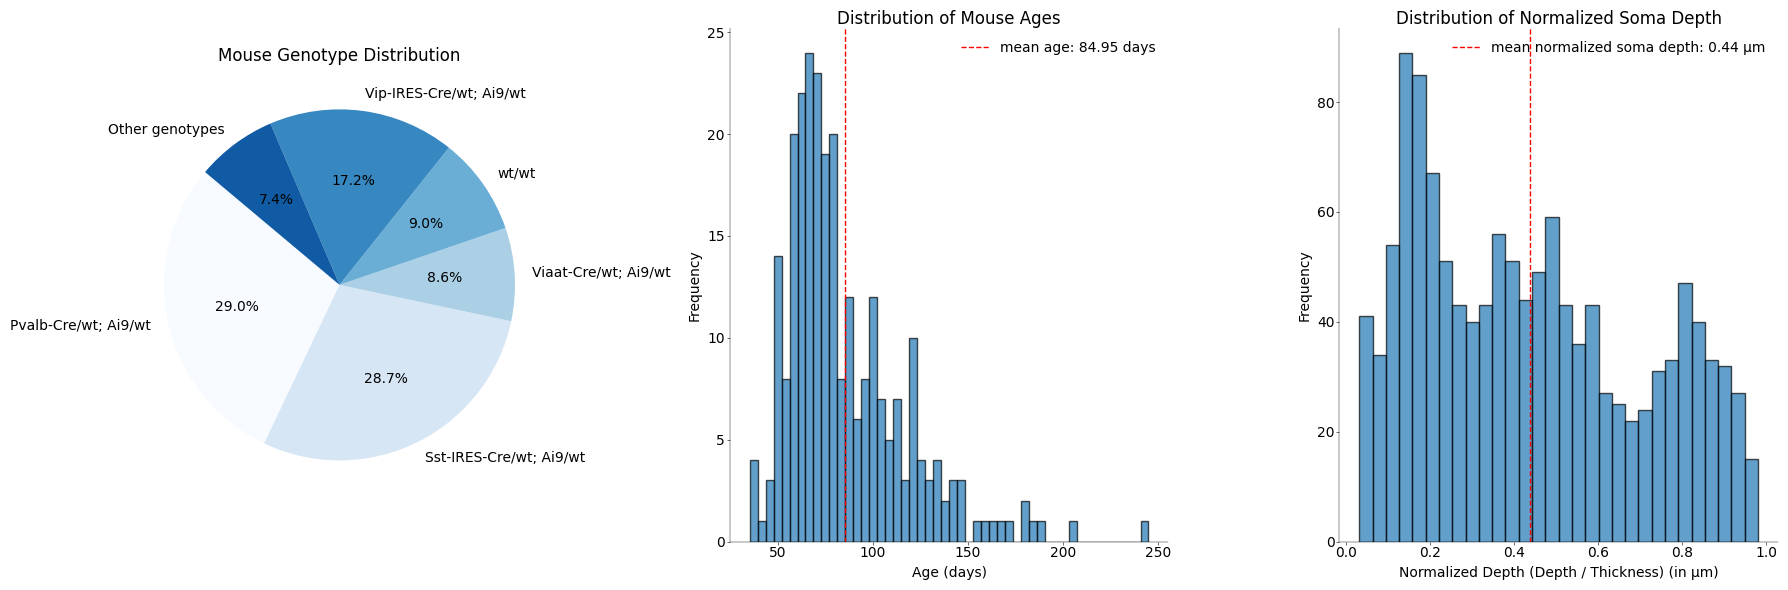

In [24]:
# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.pie(
    genotype_summary.values(),
    labels=genotype_summary.keys(),
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
)
plt.title("Mouse Genotype Distribution")

plt.subplot(1, 3, 2)
plt.hist(mouse_ages, bins=50, alpha=0.7, edgecolor="black")
plt.axvline(
    mean_age,
    color="r",
    linestyle="dashed",
    label=f"mean age: {mean_age:.2f} days",
)
plt.title("Distribution of Mouse Ages")
plt.xlabel("Age (days)")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(normalized_depth, bins=30, alpha=0.7, edgecolor="black")
plt.axvline(
    mean_depth,
    color="r",
    linestyle="dashed",
    label=f"mean normalized soma depth: {mean_depth:.2f} µm",
)
plt.xlabel("Normalized Depth (Depth / Thickness) (in µm)")
plt.ylabel("Frequency")
plt.title("Distribution of Normalized Soma Depth")
plt.legend()

plt.tight_layout()
plt.show()

The datasets consists of experiments that were being made on a mouse population of n=266 mice (48.53% / 51.47% male/female) with an average age of 84.95 days (see more detailed mouse age distribution above). The distribution of mouse genotypes can be obtained in the above pie chart ("other genotypes" summarizes all genotypes that have an occurance of less than 5%. Those are in particular Scnn1a-Tg3-Cre/wt; Ai9/wt  (0.08%), Vipr2-IRES2-Cre-D/wt; Ai9/wt (3.24%), Slc17a8-IRES2-Cre-D/wt; Ai9/wt (2.78%), Npy-Cre/wt; Ai9/wt (0.68%), Vglut3-Cre/wt; Ai9/wt (0.45%), Gnb4-IRES2-CreER2-D knock-in/wt; Ai9/wt (0.23%)).

### Transcriptomics data

In [25]:
# gene expression analysis

gene_means = np.mean(exonCounts, axis=0)
gene_means_sorted_ids = np.argsort(-gene_means)
gene_medians = np.median(exonCounts, axis=0)
gene_var = np.var(exonCounts, axis=0)

# genes that were not expressed at all
n_not_expressed = np.shape(np.where(np.sum(exonCounts, axis=0) == 0))[1]

# number of cells that express a certain gene
n_cells_per_genes = np.sum(exonCounts > 0, axis=0)
n_cells_per_genes_sorted_ids = np.argsort(-n_cells_per_genes)

C:\Users\nekur\AppData\Local\Temp\ipykernel_22956\1144123460.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


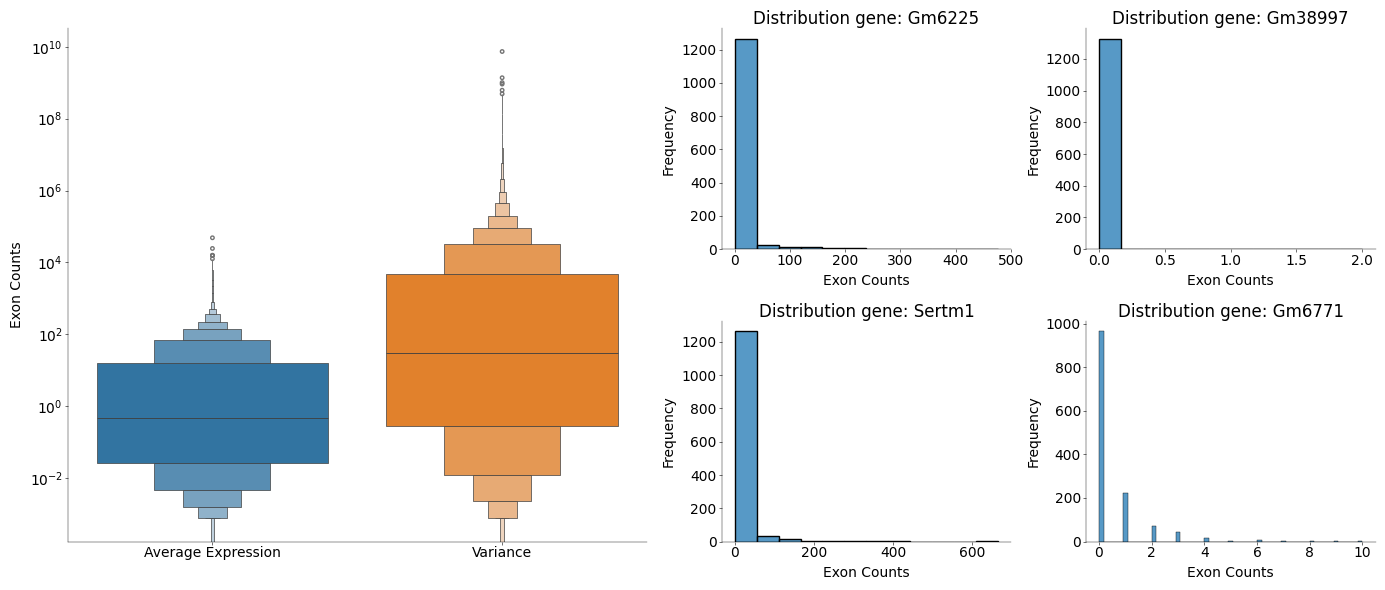

Avg exon counts of all genes: 37.74 (std: 344.96)
Avg number of cells that express a certain gene: 211.76 (std: 314.99)


The 5 most expressed genes on average:
1: CT010467.1: 	 48376.94 (std: 86179.43)
2: Gm26917: 	 24400.66 (std: 37173.28)
3: ERCC-00074: 	 15767.69 (std: 30343.80)
4: ERCC-00130: 	 15719.69 (std: 31804.46)
5: Snhg11: 	 15422.83 (std: 18551.54)
269 genes were not expressed at all


The 5 genes that were expressed by the most cells:
1: CT010467.1: 	 1327
2: mt-Rnr2: 	 1323
3: Lars2: 	 1322
4: Gm20388: 	 1321
5: Rn7s1: 	 1321


In [26]:
# Define the GridSpec layout
fig = plt.figure(figsize=(14, 6))
gs = plt.GridSpec(2, 3, width_ratios=[2, 1, 1], height_ratios=[1, 1])

ax_main = fig.add_subplot(gs[:, 0])
sns.boxenplot(data=[gene_means, gene_var], ax=ax_main)
ax_main.set_xticks([0, 1])
ax_main.set_xticklabels(["Average Expression", "Variance"])
ax_main.set_ylabel("Exon Counts")
ax_main.set_yscale("log")

np.random.seed(1)
random_genes = np.random.choice(data_exons.index, 4, replace=False)

axes = []
for i in range(2):
    for j in range(1, 3):
        ax = fig.add_subplot(gs[i, j])
        axes.append(ax)

for idx, gene in enumerate(random_genes):
    ax = axes[idx]
    sns.histplot(data_exons.loc[gene], kde=False, ax=ax)
    ax.set_title(f"Distribution gene: {gene}")
    ax.set_xlabel("Exon Counts")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# print some results
print(
    f"Avg exon counts of all genes: {np.mean(gene_means):.2f} (std: {np.std(gene_means):.2f})"
)
print(
    f"Avg number of cells that express a certain gene: {np.mean(n_cells_per_genes):.2f} (std: {np.std(n_cells_per_genes):.2f})"
)
print("\n")
print(f"The 5 most expressed genes on average:")
for i in range(5):
    print(
        f"{i+1}: {data_exons.index[gene_means_sorted_ids[i]]}: \t {gene_means[gene_means_sorted_ids[i]]:.2f} (std: {np.std(exonCounts[:, gene_means_sorted_ids[i]]):.2f})"
    )
print(f"{n_not_expressed} genes were not expressed at all")
print("\n")
print(f"The 5 genes that were expressed by the most cells:")
for i in range(5):
    print(
        f"{i+1}: {data_exons.index[n_cells_per_genes_sorted_ids[i]]}: \t {n_cells_per_genes[n_cells_per_genes_sorted_ids[i]]}"
    )

In [27]:
# cell specific expression

# how many different genes does a cell express on average
n_genes_per_cell = np.sum(data_exons.values > 0, axis=0)
n_genes_per_cell_sorted_ids = np.argsort(-n_genes_per_cell)

# get sequencing depth for each cell
seq_depth = np.sum(data_exons.values, axis=0)

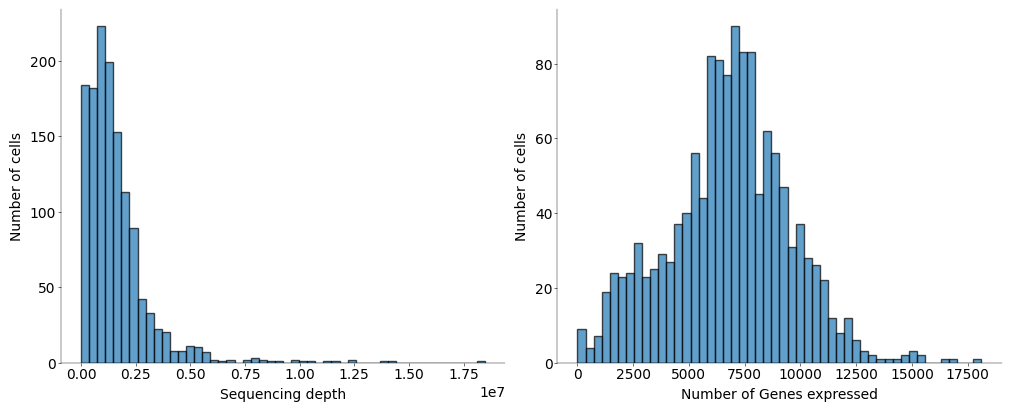

Average number of genes expressed over all cells: 6766.39 (std: 2742.47)
The 5 cells that expressed the most number of different genes:
0: 0610010F05Rik: 	 18118
1: 1110017D15Rik: 	 16845
2: 0610009L18Rik: 	 16310
3: 0610012G03Rik: 	 15527
4: 1110002J07Rik: 	 15372


The 5 cells that expressed the least number of different genes:
1: 1600014C23Rik: 	 5
2: 1700120G07Rik: 	 24
3: 1700120C18Rik: 	 26
4: 1700010B08Rik: 	 45
5: 1700080N15Rik: 	 69


In [28]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(seq_depth, bins=50, alpha=0.7, edgecolor="black")
ax[0].set_xlabel("Sequencing depth")
ax[0].set_ylabel("Number of cells")
ax[1].hist(n_genes_per_cell, bins=50, alpha=0.7, edgecolor="black")
ax[1].set_xlabel("Number of Genes expressed")
ax[1].set_ylabel("Number of cells")
plt.show()

# print results
print(
    f"Average number of genes expressed over all cells: {np.mean(n_genes_per_cell):.2f} (std: {np.std(n_genes_per_cell):.2f})"
)
print(f"The 5 cells that expressed the most number of different genes:")
for i in range(5):
    print(
        f"{i}: {data_exons.index[n_genes_per_cell_sorted_ids[i]]}: \t {n_genes_per_cell[n_genes_per_cell_sorted_ids[i]]}"
    )
print("\n")
print(f"The 5 cells that expressed the least number of different genes:")
for i in range(1, 6):
    print(
        f"{i}: {data_exons.index[n_genes_per_cell_sorted_ids[-i]]}: \t {n_genes_per_cell[n_genes_per_cell_sorted_ids[-i]]}"
    )

Due to the differences in sequencing depth and gene lenght the statistics of the exon count data shows a large variance indicating a need of normalization that counteracts these technical biases and makes the data more comparable within and across samples.

## 2) Normalize and Transform the Data ##

Normalizations and transformations help to standardize the data, making it more comparable across samples and more suitable for further analyses. We implemented the following normalizations:

##### CPM (Counts per Million):

\begin{align*}
CPM_{ij} = \frac{c_{ij}}{s_i} * 10^6
\end{align*}
with $c_{ij}$ being the number of reads of gene $j$ in sample $i$ and $s_i$ the total number reads mapped in sample $i$. CPM normalizes the exon count by the sequencing depth but is independent of the gene length. Its output is given in counts per million reads.

##### CPMedian:

\begin{align*}
CPM_{ij} = \frac{c_{ij}}{s_i} * median(s)
\end{align*}
similar to CPM but scales the reads with the median sequencing depth across all samples minimizing the impact of outliers.  

##### RPKM (Reads per kilo base of transcript per million mapped reads):

\begin{align*}
RPKM_{ij} = 10^9 * \frac{c_{ij}}{s_i * l_j}
\end{align*}
with $l_j$ being the gene length of gene $j$ ensuring a normalization with respect to the gene lenght and sequencing depth.

In [29]:
def cpm(counts):
    seq_depth = np.sum(counts, axis=1)
    normed = (counts / seq_depth[:, np.newaxis]) * 1e6
    return normed


def cpmedian(counts):
    seq_depth = np.sum(counts, axis=1)
    normed = counts / seq_depth[:, np.newaxis] * np.median(seq_depth)
    return normed


def rpkm(
    counts, lengths
):  ## Taken from https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch01.html
    """Calculate reads per kilobase transcript per million reads.

    RPKM = (10^9 * C) / (N * L)

    Where:
    C = Number of reads mapped to a gene
    N = Total mapped reads in the experiment
    L = Exon length in base pairs for a gene

    Parameters
    ----------
    counts: array, shape (N_genes, N_samples)
        RNAseq (or similar) count data where columns are individual samples
        and rows are genes.
    lengths: array, shape (N_genes,)
        Gene lengths in base pairs in the same order
        as the rows in counts.

    Returns
    -------
    normed : array, shape (N_genes, N_samples)
        The RPKM normalized counts matrix.
    """
    N = np.sum(counts, axis=0)  # sum each column to get total reads per sample
    L = lengths
    C = counts

    normed = 1e9 * C / (N[np.newaxis, :] * L[:, np.newaxis])

    return normed.T


# exonCounts = sklearn.preprocessing.normalize(exonCounts)
cpm = cpm(exonCounts)
cpmedian = cpmedian(exonCounts)
rpkm = rpkm(exonCounts.T, exonLengths)

The transformation being used in this project were applied to make the data more suitable for furher analysis by modyfying the data distributions. We used the following transformation elementwise on the count data:

##### Square Root:

\begin{align*}
x \mapsto \sqrt{x}
\end{align*}
This transformation reduces the range of the data and can therefore lead to a stabilization of the variance.

##### Logarithm:

\begin{align*}
x \mapsto log_2(x+1) 
\end{align*}
Also reduces the range of the data and reduces the impact of large values. We add $+1$ inside the logarithm to avoid the undefined computation of $log(0)$.

In [30]:
## Transforms
def sqrt_transform(counts):
    return np.sqrt(counts)


def log_transform(counts):
    return np.log2(counts + 1)

## 3) Two-Dimensional visualization ##

To plot the high dimensional exon read data, we used the dimensionality reduction techniques t_SNE and UMAP. t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique that maps high-dimensional data to lower dimensions and tries to preserves local structure. the ideaa of UMAP (Uniform Manifold Approximation and Projection). The idea is to embed the main structure of the high dimensional data into a lower dimensional space by constructing a high-dimensional graph representation of the data and then optimizing a low-dimensional graph to be as structurally similar as possible. These dimensionality reductions help in visualization of the data.

To measure the quality of the dimensionality reduction and optimize their hyperparameter, we used multiple metrics. First, let $X=\{x_1,...,x_n\}$ be the original, high dimensional data and $\hat{X}=\{\hat{x}_1,...,\hat{x}_n\}$ be its dimensionality reduction. The pairwise distance matrix is given by the euclidian distance between all datapoints:
\begin{align*}
D_{ij} = ||x_i - x_j||_2 (\text{high dimension}) \quad \hat{D}_{ij} = ||\hat{x}_i - \hat{x}_j||_2 \text{(low dimension)}.
\end{align*}

##### Distance Correlation
To determine the correlation between the distances in the high dimensional and the low dimensional data we use the metric
\begin{align*}
corr(D, \hat{D}) = \frac{cov(D, \hat{D})}{\sqrt{cov(D,D) cov(\hat{D}, \hat{D})}}
\end{align*}
with the covariance of two matrices $cov(X, Y)$ being computed by firstly double centering both matrices by applying the elemtwise transformation
\begin{align*}
\tilde{X}_{ij} = X_{ij} - \bar{X}_{\cdot j} - \bar{X}_{i \cdot} + \bar{X}
\end{align*}
with $\bar{X}_{\cdot j}$ being the mean of the column $j$ of $X$, $\bar{X}_{i \cdot}$ the mean of the row $i$, and $\bar{X}$ being the overall mean of all elements in $X$ (equivalently for $Y$) and then computing
\begin{align*}
cov(\mathbf{X}, \mathbf{Y}) = \sqrt{\frac{1}{n^2} \sum_{i=1}^{n} \sum_{j=1}^{n} \tilde{X}_{ij} \tilde{Y}_{ij}}.
\end{align*}
The value of the correlation ranges between −1 and +1. +1 identifying a perfect  (increasing) linear relationship, −1 in the case of a perfect inverse (decreasing) linear relationship, and 0 no correlation.

##### Rank Correlation
The rank correlation is defined by taking the two distance matrices and ranking each element of the individual matrices. The highest value gets rank 1, the second highest gets rank 2,.... For ties, assign the average of the possible ranks. After obtaining these rank matrices, we compute the Spearman Rank correlation between the two matrices.

##### k-nearest neigbors
For KNN for each datapoint $x_i$ we took the k=15 nearest neighbors (the 15 datapoints with the smallest euclidian distance to $x_i$), yielding the dataset of the nearest neighbors $N_{x_i}$. The same was done for the correspinding dimensionality redcution $\hat{x}_i$ yielding the set $N_{\hat{x}_i}$. The overlap between the two sets was defined as the number of datapoints for which the high dimensional data point $y \in N_{x_i}$ and its corresponding dimensionality reduction $\hat{y} \in N_{\hat{x}_i}$. We receive the accuracy of that datapoint $accuracy_i=\frac{overlap_i}{k}$. The overal KNN score was then defined as the average of all accuracy scores. 

##### Density Variance
The density variance is a simple form of grid cell variance comparison.

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

c:\Users\nekur\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nekur\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Condition            dist_corr  rank_corr  knn acc    density var
-----------------------------------------------------------------
Raw + None           0.81       0.75       0.41       14.58     
Raw + Log            0.37       0.13       0.12       27.44     
Raw + Sqrt           0.61       0.42       0.23       13.38     
CPM + None           0.86       0.77       0.42       9.88      
CPM + Log            0.43       0.16       0.10       16.48     
CPM + Sqrt           0.57       0.28       0.24       4.94      
CPMedian + None      0.86       0.78       0.42       10.72     
CPMedian + Log       0.42       0.15       0.10       15.04     
CPMedian + Sqrt      0.57       0.28       0.24       4.88      
RPKM + None          0.85       0.82       0.42       4.69      
RPKM + Log           0.31       0.06       0.07       23.57     
RPKM + Sqrt          0.80       0.71       0.28       11.34     


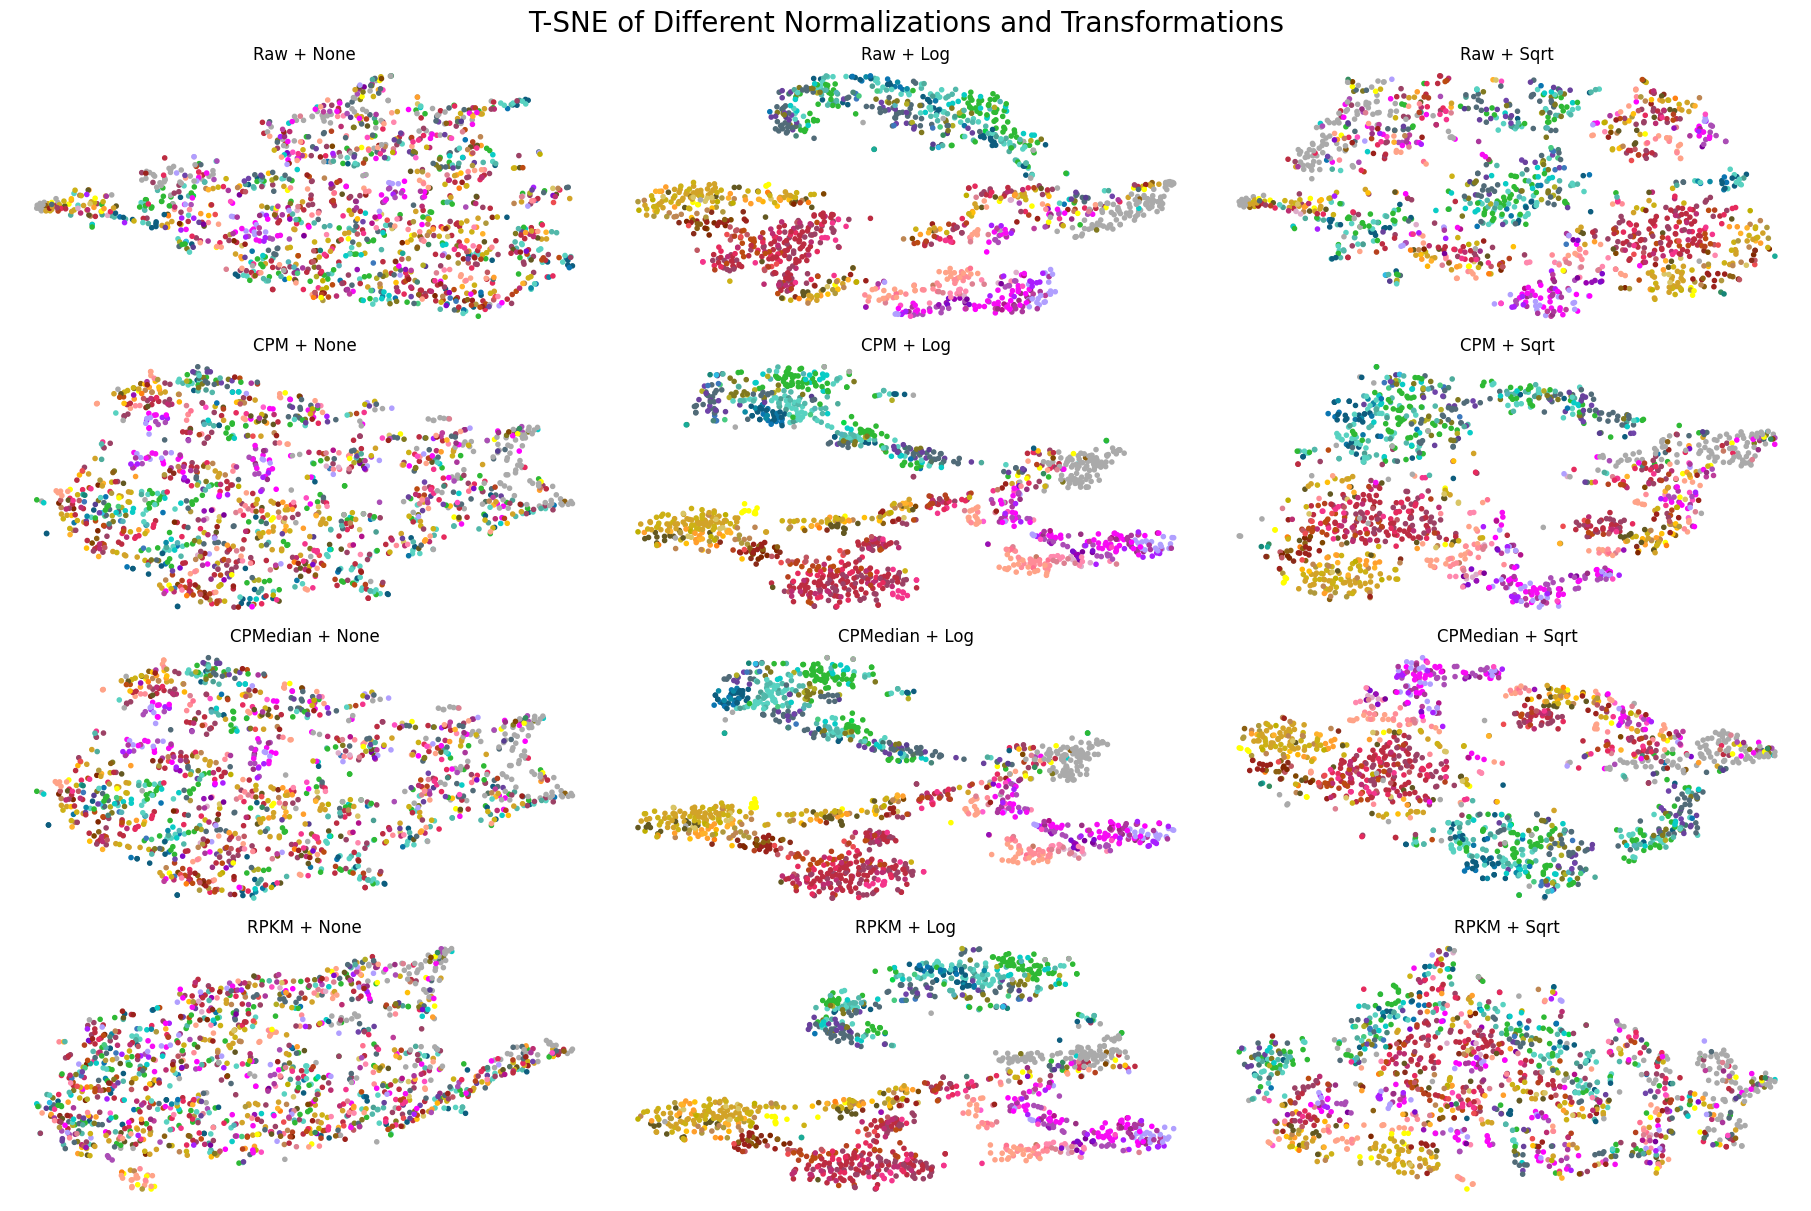

In [32]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata, spearmanr
from sklearn.metrics import silhouette_score


def distance_covariance(X, Y):
    n = X.shape[0]
    X -= X.mean(axis=0) + X.mean(axis=1)[:, np.newaxis] - X.mean()
    Y -= Y.mean(axis=0) + Y.mean(axis=1)[:, np.newaxis] - Y.mean()
    dcov = np.sqrt((X * Y).sum() / (n * n))
    return dcov


def distance_correlation(X, Y):
    dcov_XY = distance_covariance(X, Y)
    dcov_XX = distance_covariance(X, X)
    dcov_YY = distance_covariance(Y, Y)
    dcor = dcov_XY / np.sqrt(dcov_XX * dcov_YY)
    return dcor


normalizations = {
    "Raw": exonCounts,
    "CPM": cpm,
    "CPMedian": cpmedian,
    "RPKM": rpkm,
}

transformations = {
    "None": lambda x: x,
    "Log": log_transform,
    "Sqrt": sqrt_transform,
}

fig, axes = plt.subplots(
    len(normalizations), len(transformations), figsize=(18, 12)
)
fig.suptitle(
    "T-SNE of Different Normalizations and Transformations", fontsize=20
)

measures = np.zeros((len(normalizations), len(transformations), 4))

for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        data = norm_data[:, gene_var > np.sort(gene_var)[-501]]
        data_transformed = trans_func(data)
        pca_result = PCA(n_components=50).fit_transform(data_transformed)
        tsne = TSNE(n_components=2, perplexity=30)
        tsne_results = tsne.fit_transform(pca_result)

        ax = axes[i, j]
        ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
        ax.set_title(f"{norm_name} + {trans_name}", fontsize=12)
        ax.axis("off")

        # calculate pairwise (cell) distances in 2d and high dimensional space
        dist_hd = squareform(pdist(data))
        dist_ld = squareform(pdist(tsne_results))

        # calculate distance correlations
        dcor = distance_correlation(dist_hd, dist_ld)
        measures[i, j, 0] = dcor

        # calculate distance ranks
        ranks_hd = rankdata(dist_hd)
        ranks_ld = rankdata(dist_ld)
        # calculate correlation of ranks
        spearman_corr, _ = spearmanr(ranks_hd, ranks_ld)
        measures[i, j, 1] = spearman_corr

        # calculate the knn for each cell in high and low dimensional space
        k = 15
        knn_hd = np.array([np.argsort(x)[1 : k + 1] for x in dist_hd])
        knn_ld = np.array([np.argsort(x)[1 : k + 1] for x in dist_ld])
        # calculate the number of overlapping neighbors
        accuracy = np.sum(
            [len(set(x) & set(y)) for x, y in zip(knn_hd, knn_ld)]
        ) / (knn_hd.shape[0] * k)
        measures[i, j, 2] = accuracy

        # calculate point density variance
        mins = np.min(tsne_results, axis=0)
        maxs = np.max(tsne_results, axis=1)
        # kde = KernelDensity(kernel="gaussian", bandwidth=10).fit(tsne_results)
        x_grid = np.linspace(mins[0] - 1, maxs[0] + 1, 20)
        y_grid = np.linspace(mins[1] - 1, maxs[1] + 1, 20)
        densities = np.zeros(len(x_grid) * len(y_grid))
        pos = 0
        for x, _ in enumerate(x_grid[:-1]):
            for y, _ in enumerate(y_grid[:-1]):
                densities[pos] = np.sum(
                    (
                        (tsne_results[:, 0] >= x_grid[x])
                        & (tsne_results[:, 0] < x_grid[x + 1])
                        & (tsne_results[:, 1] >= y_grid[y])
                        & (tsne_results[:, 1] < y_grid[y + 1])
                    )
                )
                pos += 1
        measures[i, j, 3] = np.var(densities)


# print measures as table
print(
    f"{'Condition':<20} {'dist_corr':<10} {'rank_corr':<10} {'knn acc':<10} {'density var':<10}"
)
print("-" * 65)
for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        condition = f"{norm_name} + {trans_name}"
        print(
            f"{condition:<20} {measures[i, j, 0]:<10.2f} {measures[i, j, 1]:<10.2f} {measures[i, j, 2]:<10.2f} {measures[i, j, 3]:<10.2f}"
        )

In [33]:
import umap.umap_ as umap

c:\Users\nekur\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nekur\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nekur\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nekur\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarnin

Condition            dist_corr  rank_corr  knn acc    density var
-----------------------------------------------------------------
Raw + None           0.81       0.74       0.35       1.78      
Raw + Log            0.65       0.44       0.25       31.91     
Raw + Sqrt           0.72       0.50       0.28       6.25      
CPM + None           0.87       0.77       0.38       6.56      
CPM + Log            0.68       0.46       0.29       66.62     
CPM + Sqrt           0.75       0.51       0.34       9.77      
CPMedian + None      0.87       0.77       0.38       6.32      
CPMedian + Log       0.67       0.47       0.29       68.26     
CPMedian + Sqrt      0.74       0.49       0.35       8.28      
RPKM + None          0.87       0.84       0.39       6.48      
RPKM + Log           0.66       0.46       0.31       60.11     
RPKM + Sqrt          0.85       0.69       0.32       3.34      


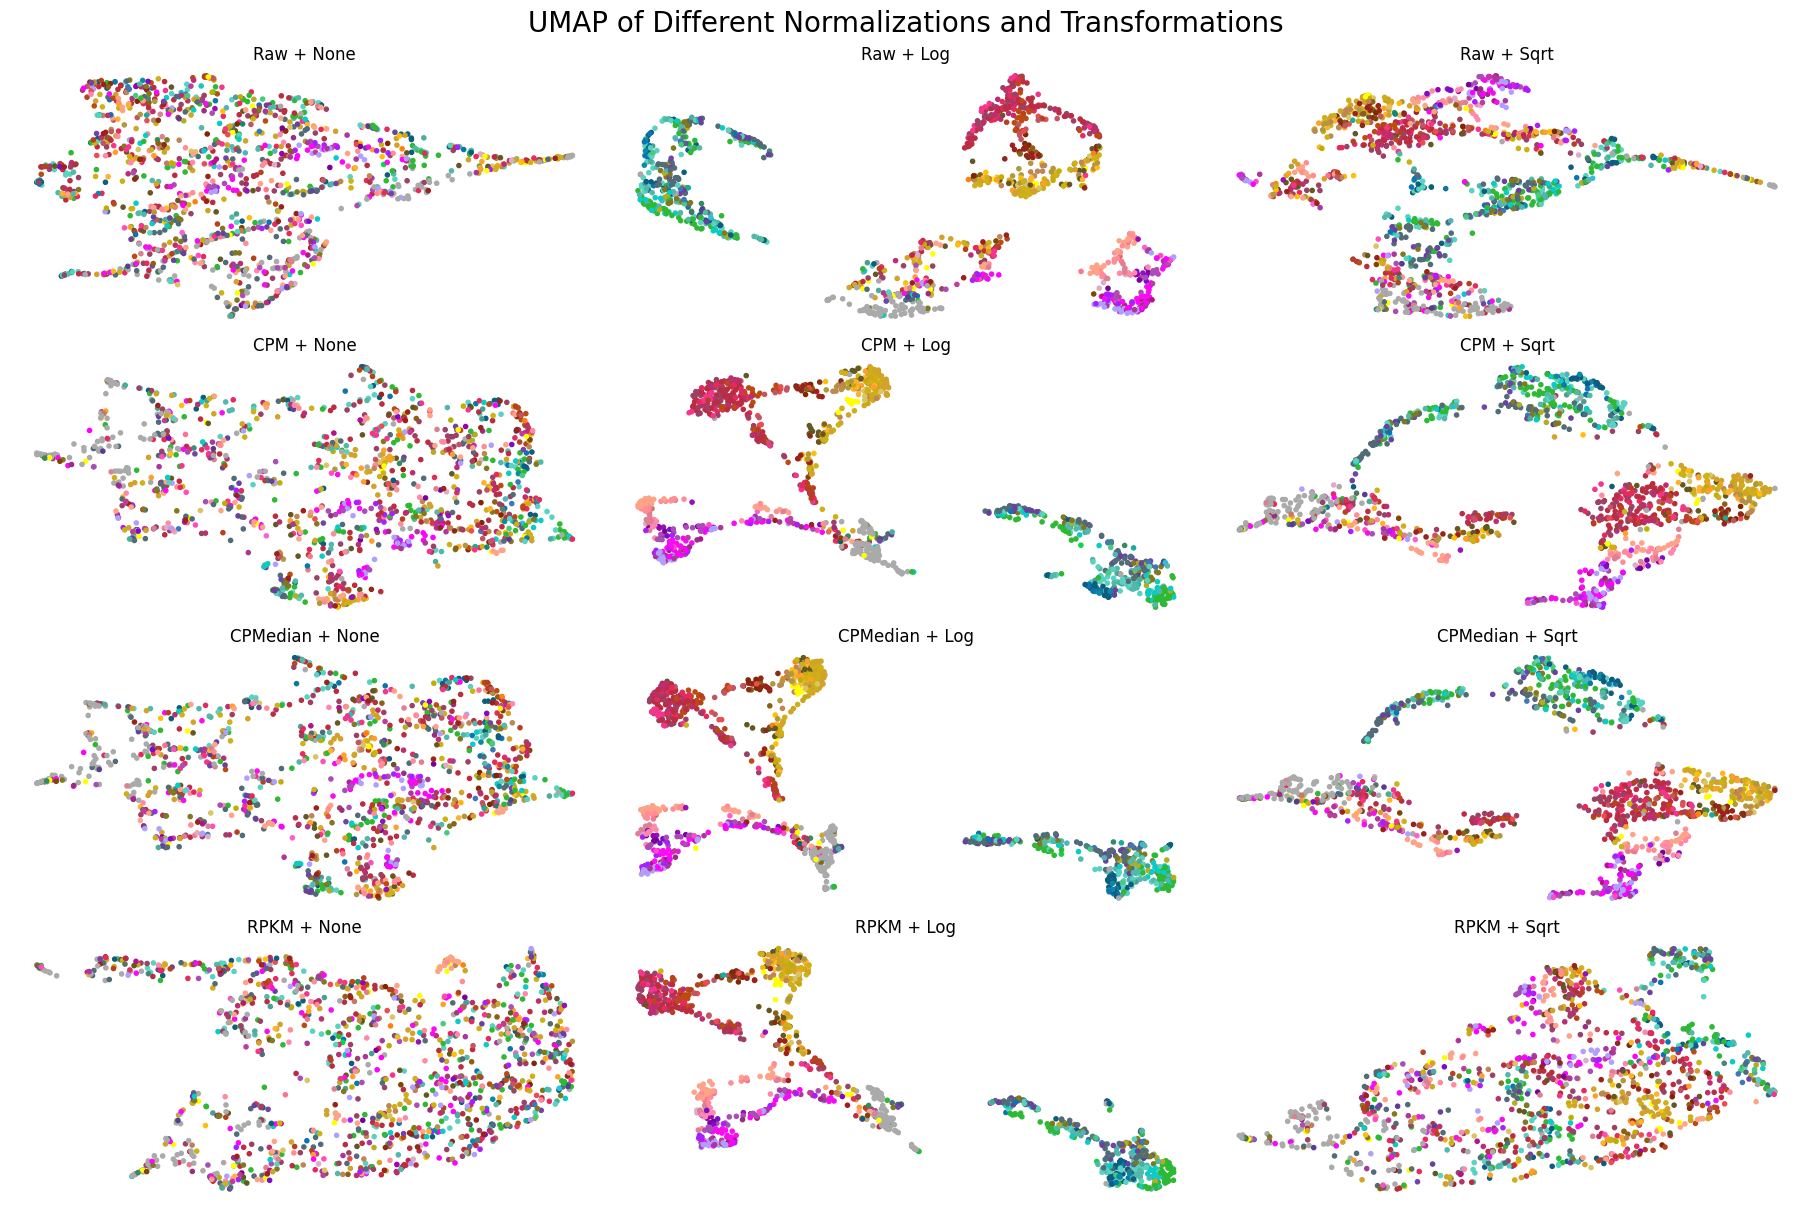

In [34]:
normalizations = {
    "Raw": exonCounts,
    "CPM": cpm,
    "CPMedian": cpmedian,
    "RPKM": rpkm,
}

transformations = {
    "None": lambda x: x,
    "Log": log_transform,
    "Sqrt": sqrt_transform,
}

fig, axes = plt.subplots(
    len(normalizations), len(transformations), figsize=(18, 12)
)
fig.suptitle(
    "UMAP of Different Normalizations and Transformations", fontsize=20
)

measures = np.zeros((len(normalizations), len(transformations), 4))

for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        data = norm_data[:, gene_var > np.sort(gene_var)[-501]]
        data_transformed = trans_func(data)
        pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
            data_transformed
        )
        umap_model = umap.UMAP(random_state=7)
        umap_results = umap_model.fit_transform(pca_result)

        ax = axes[i, j]
        ax.scatter(umap_results[:, 0], umap_results[:, 1], c=cluster_colors)
        ax.set_title(f"{norm_name} + {trans_name}", fontsize=12)
        ax.axis("off")

        # calculate pairwise (cell) distances in 2d and high dimensional space
        dist_hd = squareform(pdist(data_transformed))
        dist_ld = squareform(pdist(umap_results))

        # calculate distance correlations
        dcor = distance_correlation(dist_hd, dist_ld)
        measures[i, j, 0] = dcor

        # calculate distance ranks
        ranks_hd = rankdata(dist_hd)
        ranks_ld = rankdata(dist_ld)
        # calculate correlation of ranks
        spearman_corr, _ = spearmanr(ranks_hd, ranks_ld)
        measures[i, j, 1] = spearman_corr

        # calculate the knn for each cell in high and low dimensional space
        k = 15
        knn_hd = np.array([np.argsort(x)[1 : k + 1] for x in dist_hd])
        knn_ld = np.array([np.argsort(x)[1 : k + 1] for x in dist_ld])
        # calculate the number of overlapping neighbors
        accuracy = np.sum(
            [len(set(x) & set(y)) for x, y in zip(knn_hd, knn_ld)]
        ) / (knn_hd.shape[0] * k)
        measures[i, j, 2] = accuracy

        # calculate point density variance
        mins = np.min(umap_results, axis=0)
        maxs = np.max(umap_results, axis=1)
        # kde = KernelDensity(kernel="gaussian", bandwidth=10).fit(tsne_results)
        x_grid = np.linspace(mins[0] - 1, maxs[0] + 1, 20)
        y_grid = np.linspace(mins[1] - 1, maxs[1] + 1, 20)
        densities = np.zeros(len(x_grid) * len(y_grid))
        pos = 0
        for x, _ in enumerate(x_grid[:-1]):
            for y, _ in enumerate(y_grid[:-1]):
                densities[pos] = np.sum(
                    (
                        (umap_results[:, 0] >= x_grid[x])
                        & (umap_results[:, 0] < x_grid[x + 1])
                        & (umap_results[:, 1] >= y_grid[y])
                        & (umap_results[:, 1] < y_grid[y + 1])
                    )
                )
                pos += 1
        measures[i, j, 3] = np.var(densities)


# print measures as table
print(
    f"{'Condition':<20} {'dist_corr':<10} {'rank_corr':<10} {'knn acc':<10} {'density var':<10}"
)
print("-" * 65)
for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        condition = f"{norm_name} + {trans_name}"
        print(
            f"{condition:<20} {measures[i, j, 0]:<10.2f} {measures[i, j, 1]:<10.2f} {measures[i, j, 2]:<10.2f} {measures[i, j, 3]:<10.2f}"
        )


plt.show()

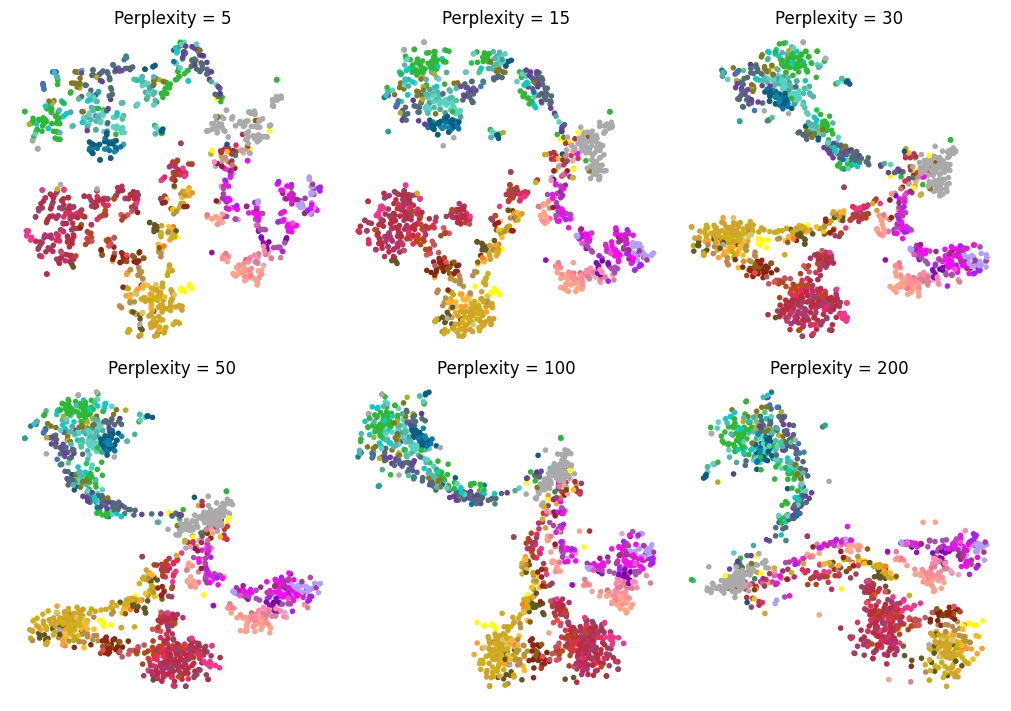

In [35]:
data_final = log_transform(cpmedian)
data_final = data_final[:, gene_var > np.sort(gene_var)[-501]]

perplexities = [5, 15, 30, 50, 100, 200]
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes_flat = np.ravel(axes)

for idx, perplexity in enumerate(perplexities):
    ax = axes_flat[idx]

    pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
        data_final
    )
    tsne = sklearn.manifold.TSNE(
        n_components=2, perplexity=perplexity, random_state=7
    )
    tsne_results = tsne.fit_transform(pca_result)

    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
    ax.set_title(
        f"Perplexity = {perplexity}",
        fontsize=12,
    )
    ax.axis("off")

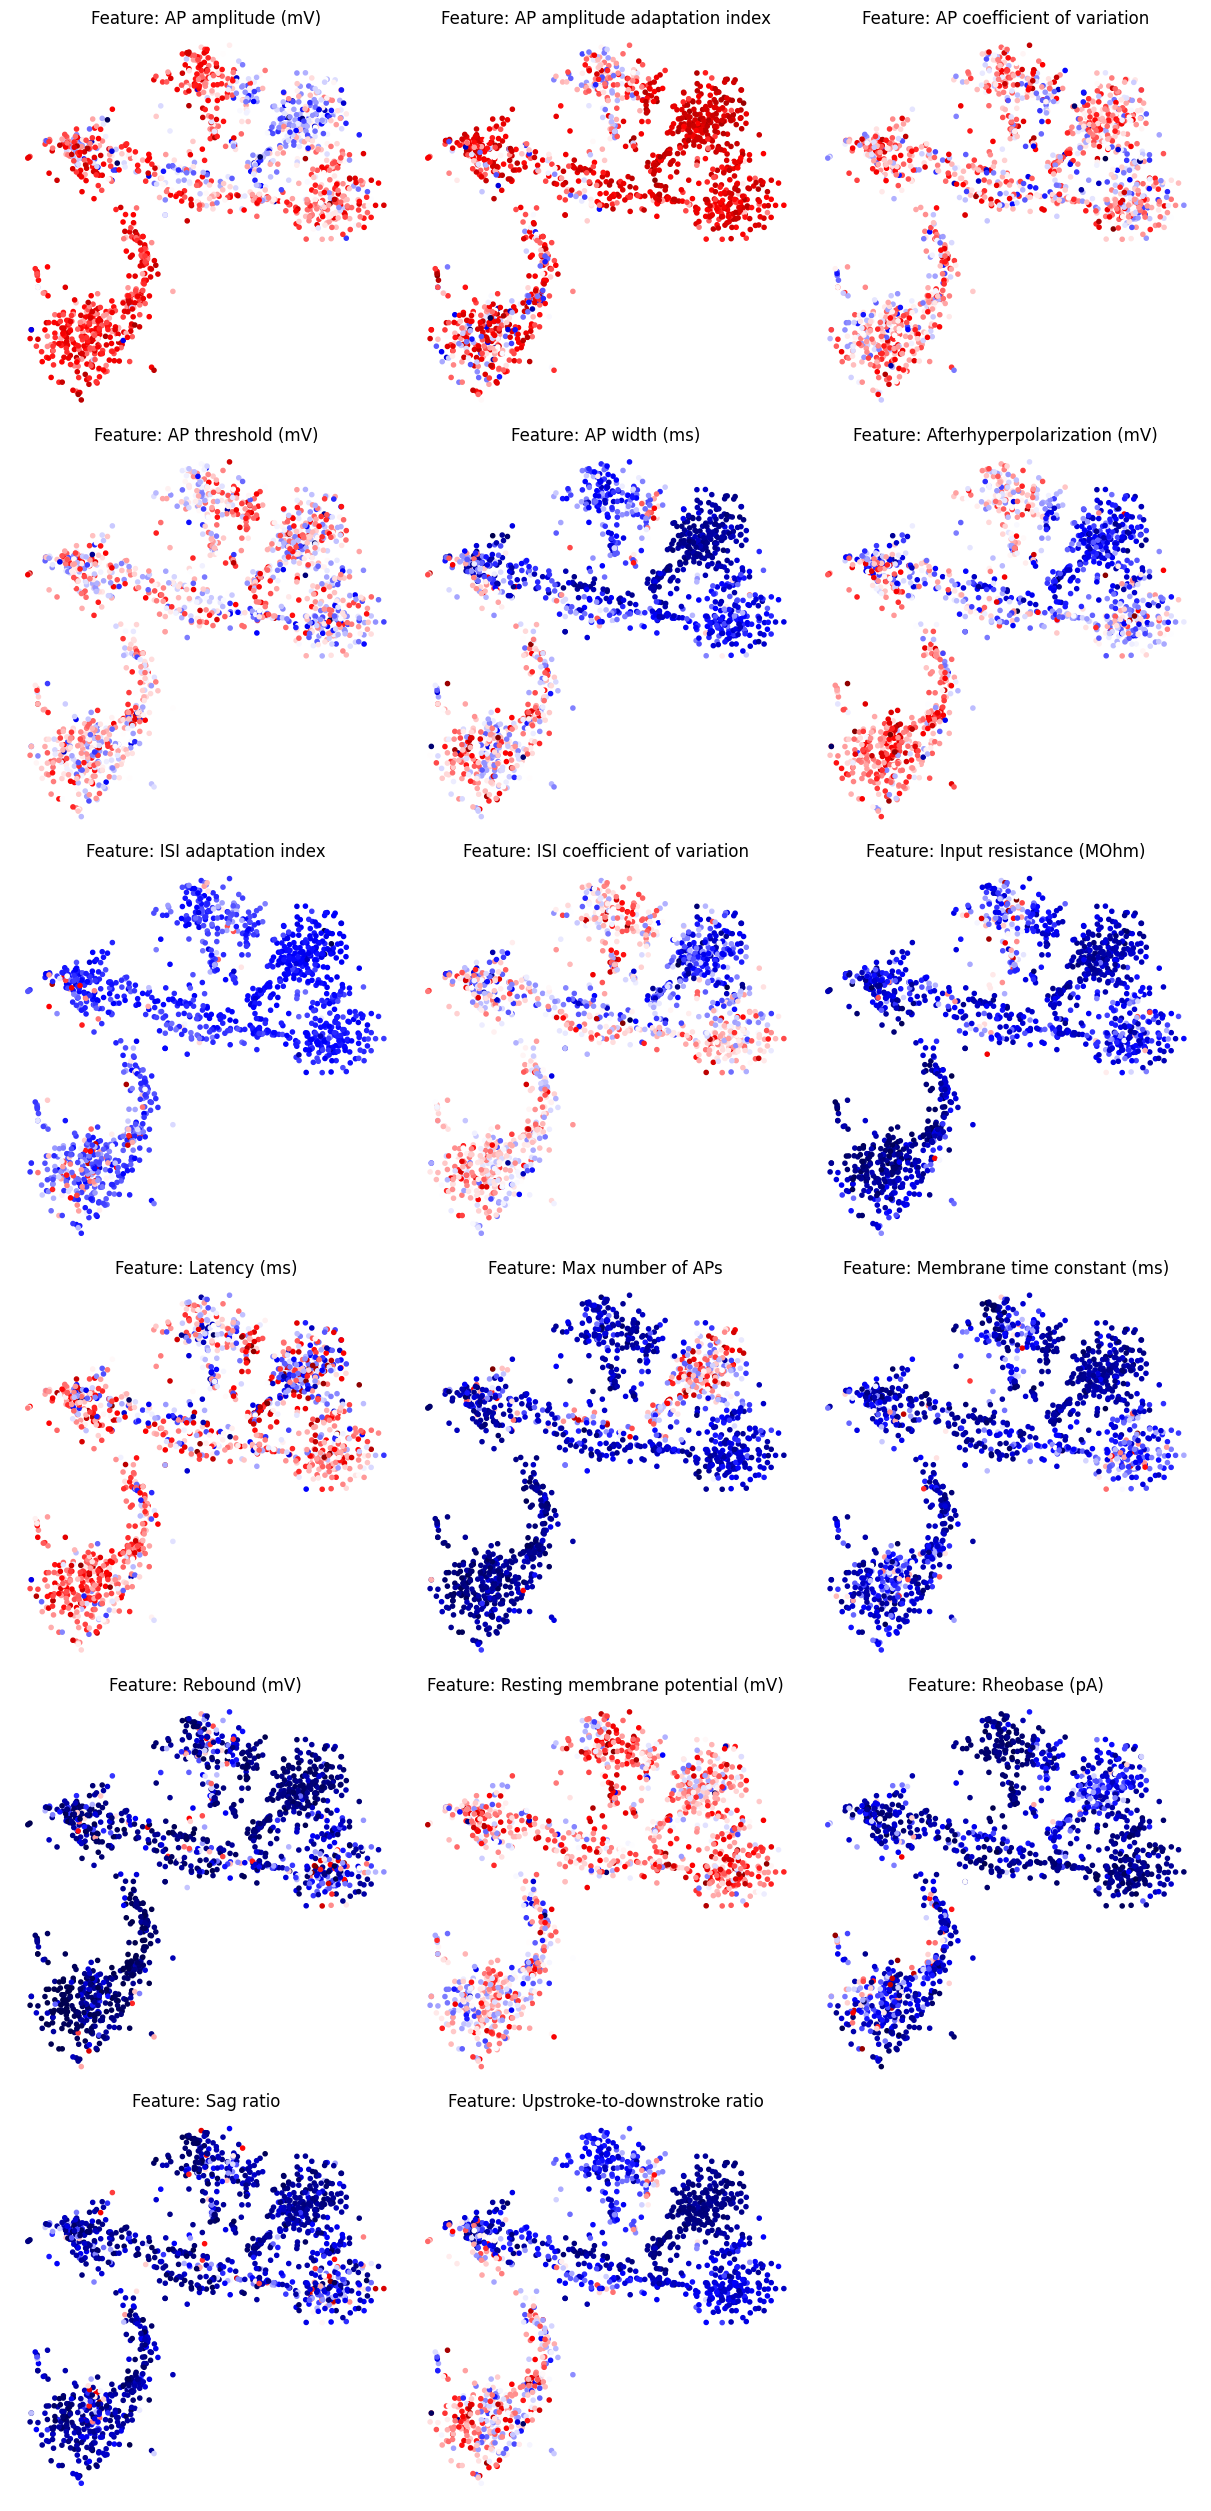

In [36]:
from matplotlib.colors import Normalize

fig, axes = plt.subplots(6, 3, figsize=(12, 25))
axes_flat = np.ravel(axes)
pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
    data_final[keepcells]
)
tsne = sklearn.manifold.TSNE(
    n_components=2, perplexity=perplexity, random_state=7
)
tsne_results = tsne.fit_transform(pca_result)


for idx in range(0, len(X[0, :])):
    ax = axes_flat[idx]
    x = X[:, idx]
    norm = Normalize(vmin=min(x), vmax=max(x))
    colors = plt.cm.seismic(norm(x))

    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)
    ax.set_title(
        f"Feature: {ephysNames[idx]}",
        fontsize=12,
    )
    ax.axis("off")
axes_flat[17].axis("off")
plt.show()

c:\Users\nekur\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


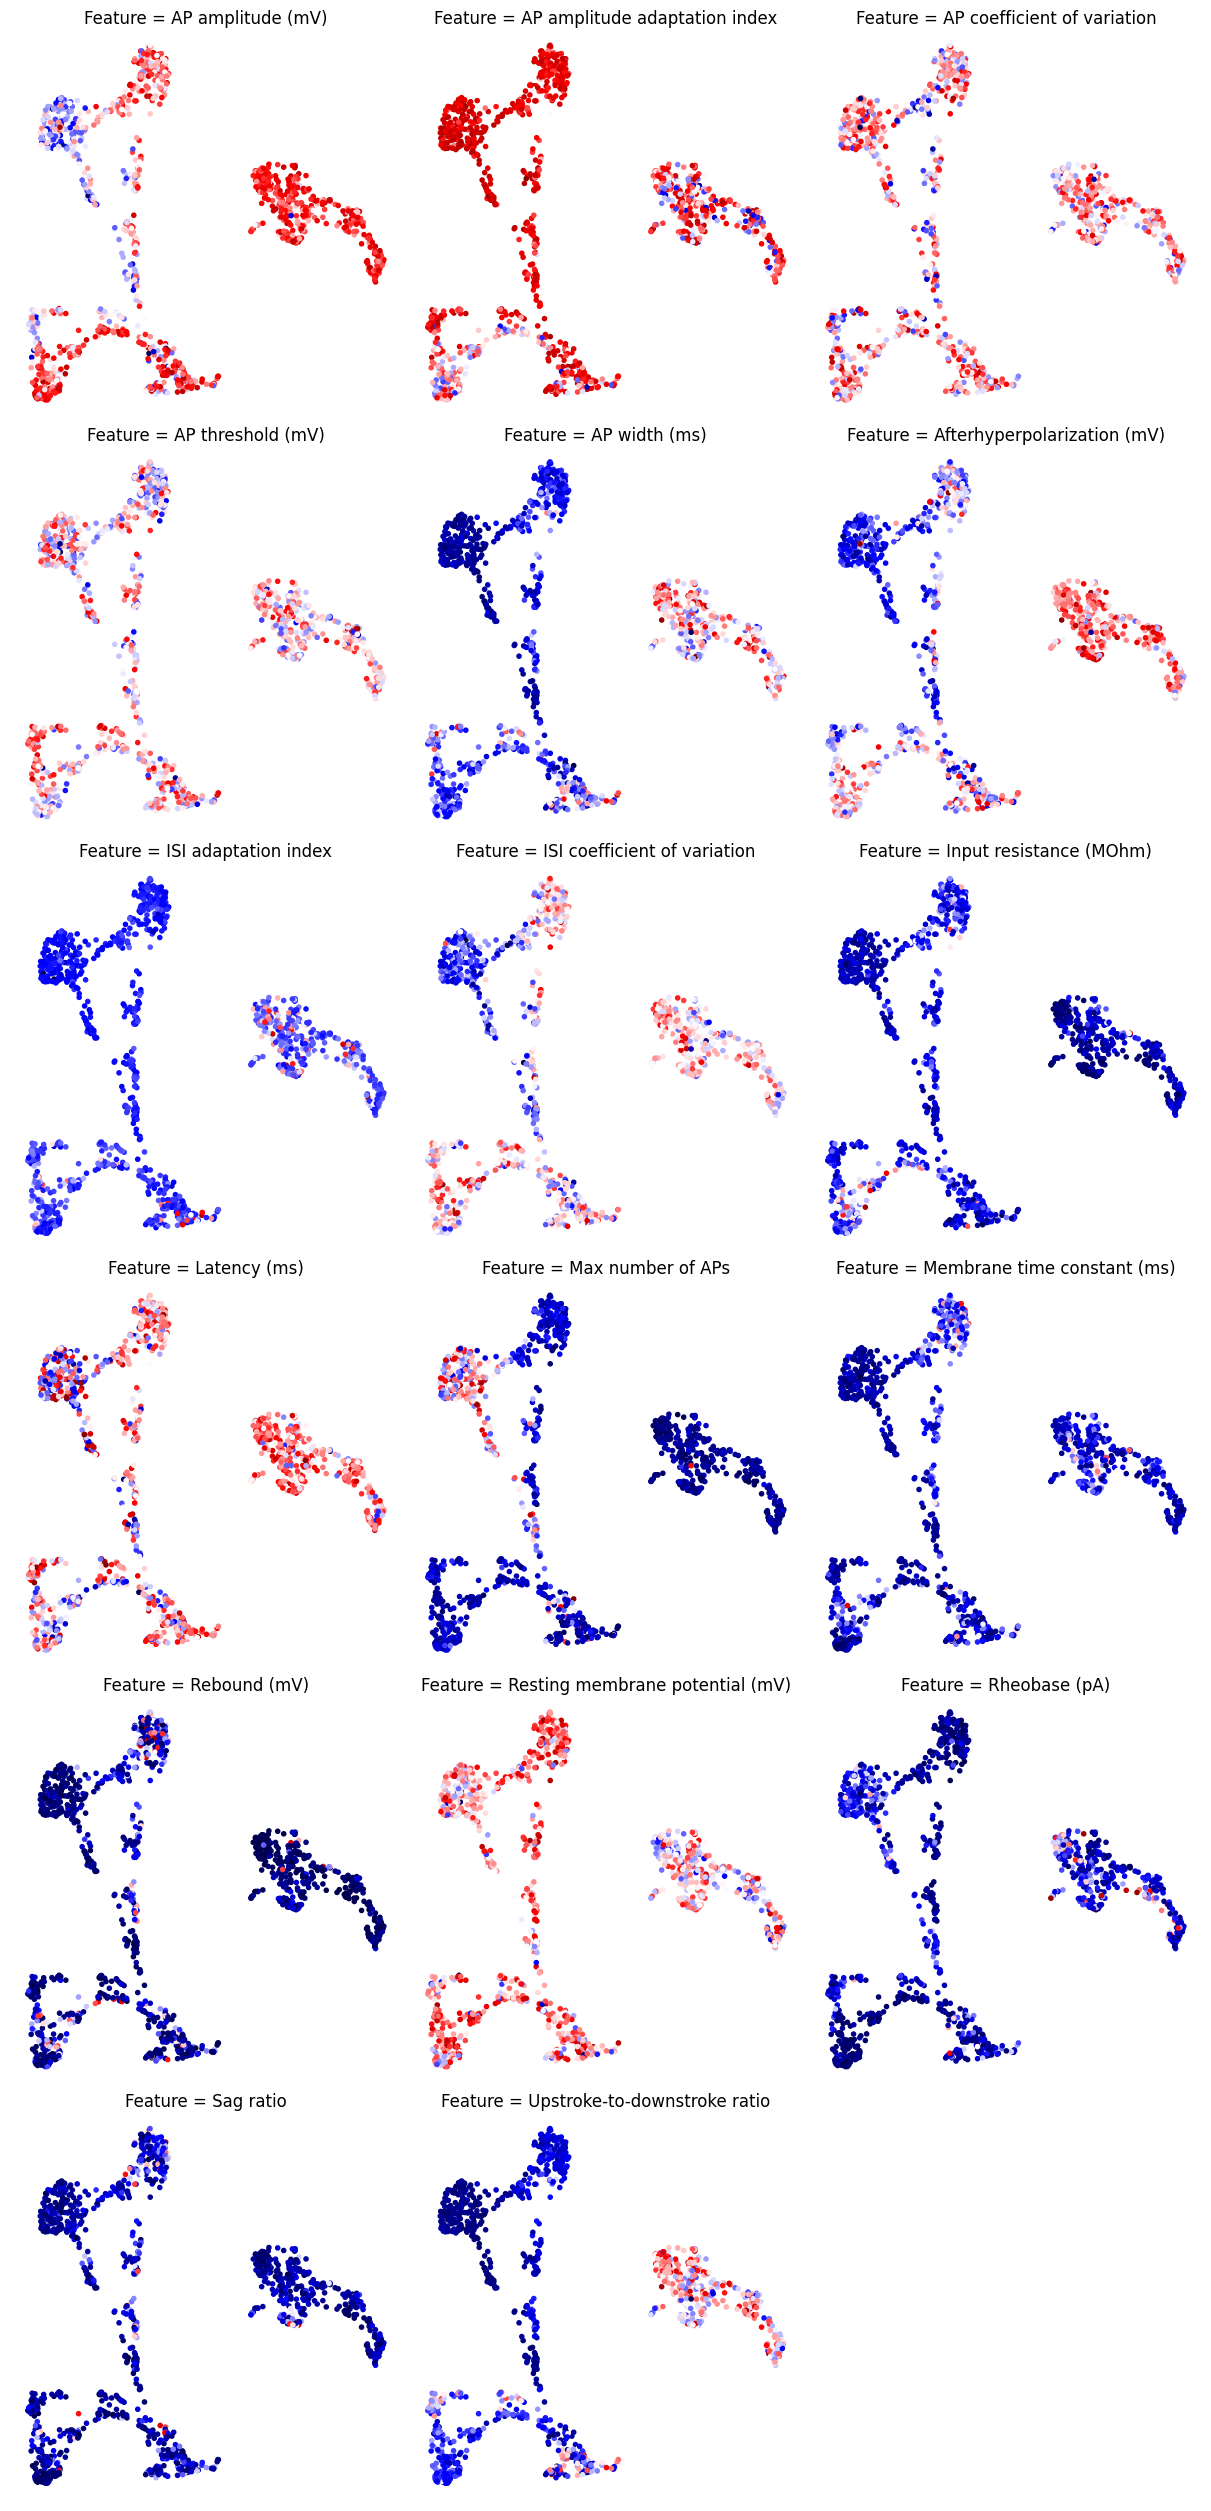

In [37]:
fig, axes = plt.subplots(6, 3, figsize=(12, 25))
axes_flat = np.ravel(axes)

umap_model = umap.UMAP(random_state=7)
umap_results = umap_model.fit_transform(pca_result)

for idx in range(0, len(X[0, :])):
    ax = axes_flat[idx]
    x = X[:, idx]
    norm = Normalize(vmin=min(x), vmax=max(x))
    colors = plt.cm.seismic(norm(x))

    ax.scatter(umap_results[:, 0], umap_results[:, 1], c=colors)
    ax.set_title(
        f"Feature = {ephysNames[idx]}",
        fontsize=12,
    )
    ax.axis("off")
axes_flat[17].axis("off")
plt.show()

## 4) Clustering ##

In [38]:
import igraph as ig
from sklearn.neighbors import kneighbors_graph
import leidenalg as la

print(f"Amount of Clusters in Original Data: {len(np.unique(cluster_colors))}")

Amount of Clusters in Original Data: 78


In [39]:
clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

In [40]:
pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
    data_final
)
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30, random_state=7)
tsne_results = tsne.fit_transform(pca_result)
umap_model = umap.UMAP(random_state=7)
umap_results = umap_model.fit_transform(pca_result)

results = tsne_results

c:\Users\nekur\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


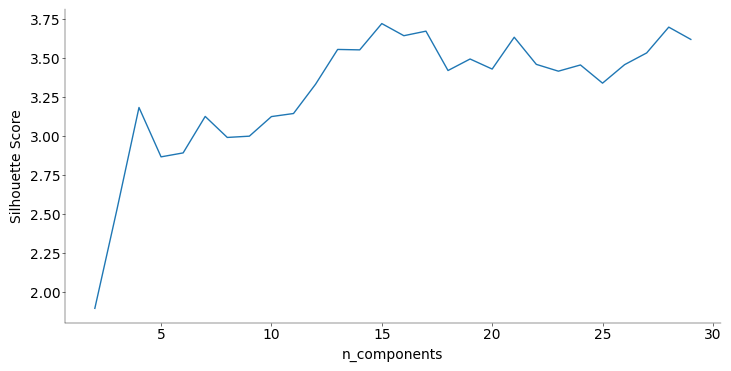

n_components with highest silhouette score: 15


In [41]:
## GMM
from sklearn.mixture import GaussianMixture

L_n_components = np.arange(2, 30, 1)
L_gmm = []
for n_components in L_n_components:
    gmm = GaussianMixture(n_components=n_components, random_state=7).fit(
        data_final
    )
    sil_score = sklearn.metrics.davies_bouldin_score(
        data_final, gmm.predict(data_final)
    )
    L_gmm.append(sil_score)
plt.plot(L_n_components, L_gmm)
plt.ylabel("Silhouette Score")
plt.xlabel("n_components")
plt.show()
print(
    f"n_components with highest silhouette score: {L_n_components[np.argmax(L_gmm)]}"
)

100%|██████████| 380/380 [00:06<00:00, 55.01it/s]


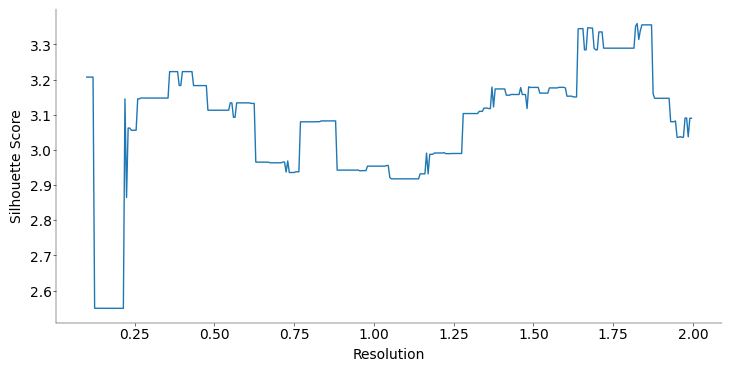

Resolution with highest silhouette score: 1.83


In [42]:
### Leiden
import tqdm

A = kneighbors_graph(data_final, 15)
sources, targets = A.nonzero()
A = ig.Graph(zip(sources, targets))
resolutions = np.arange(0.1, 2, 0.005)
L_Leiden = []
for resolution in tqdm.tqdm(resolutions):
    partition = la.find_partition(
        A,
        la.RBConfigurationVertexPartition,
        resolution_parameter=resolution,
    )
    sil_score = sklearn.metrics.davies_bouldin_score(
        data_final, partition.membership
    )
    L_Leiden.append(sil_score)
plt.plot(resolutions, L_Leiden)
plt.ylabel("Silhouette Score")
plt.xlabel("Resolution")
plt.show()
print(
    f"Resolution with highest silhouette score: {resolutions[np.argmax(L_Leiden)]:.2f}"
)

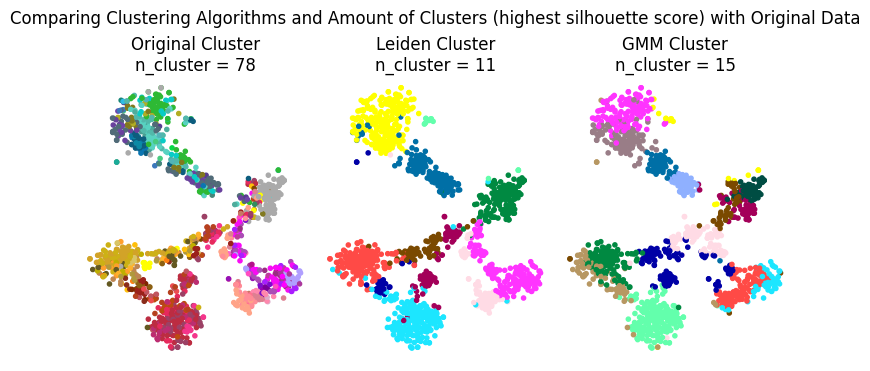

In [43]:
fig, axes = plt.subplots(1, 3)
fig.suptitle(
    "Comparing Clustering Algorithms and Amount of Clusters (highest silhouette score) with Original Data"
)

partition = la.find_partition(
    A,
    la.RBConfigurationVertexPartition,
    resolution_parameter=resolutions[np.argmax(L_Leiden)],
)
gmm_labels = (
    GaussianMixture(
        n_components=L_n_components[np.argmax(L_gmm)], random_state=7
    )
    .fit(data_final)
    .predict(data_final)
)

axes[0].scatter(results[:, 0], results[:, 1], c=cluster_colors)
axes[1].scatter(
    results[:, 0],
    results[:, 1],
    c=np.array(clusterCols)[partition.membership],
)
axes[2].scatter(
    results[:, 0],
    results[:, 1],
    c=np.array(clusterCols)[gmm_labels],
)

axes[0].set_title(
    f"Original Cluster\nn_cluster = {len(np.unique(cluster_colors))}"
)
axes[1].set_title(
    f"Leiden Cluster\nn_cluster = {len(np.unique(partition.membership))}"
)
axes[2].set_title(f"GMM Cluster\nn_cluster = {len(np.unique(gmm_labels))}")
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")
plt.show()

C:\Users\nekur\AppData\Local\Temp\ipykernel_22956\4068114877.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


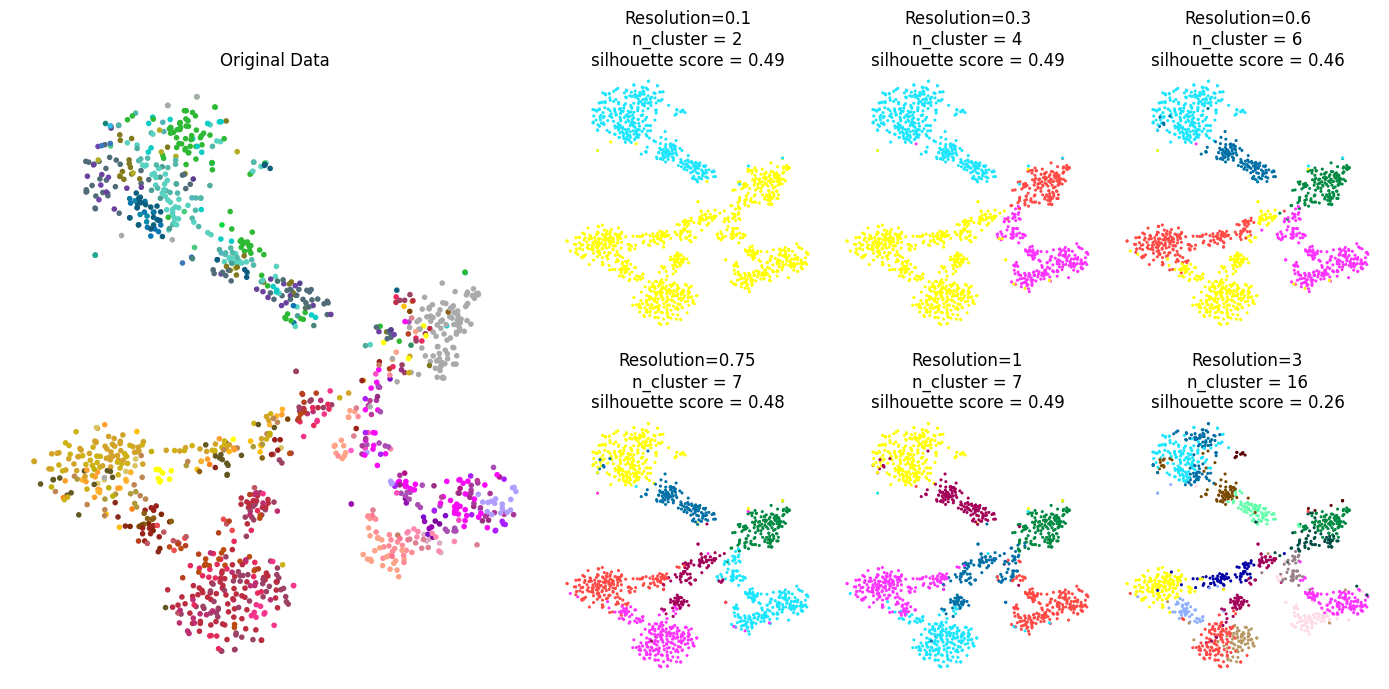

In [44]:
fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(2, 4, width_ratios=[2, 1, 1, 1])

ax_big = fig.add_subplot(gs[:, 0])
ax_big.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
ax_big.set_title("Original Data")
ax_big.axis("off")

axes = []
for row in range(2):
    for col in range(1, 4):
        axes.append(fig.add_subplot(gs[row, col]))

resolutions = [0.1, 0.3, 0.6, 0.75, 1, 3]
for idx, resolution in enumerate(resolutions):
    ax = axes[idx]
    partition = la.find_partition(
        A, la.RBConfigurationVertexPartition, resolution_parameter=resolution
    )
    sil_score = sklearn.metrics.silhouette_score(
        tsne_results, partition.membership
    )
    ax.scatter(
        tsne_results[:, 0],
        tsne_results[:, 1],
        c=np.array(clusterCols)[partition.membership],
        s=6,
    )
    ax.set_title(
        f"Resolution={resolution}\nn_cluster = {len(np.unique(partition.membership))}\nsilhouette score = {sil_score:.2f}"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

## 5) Correlation

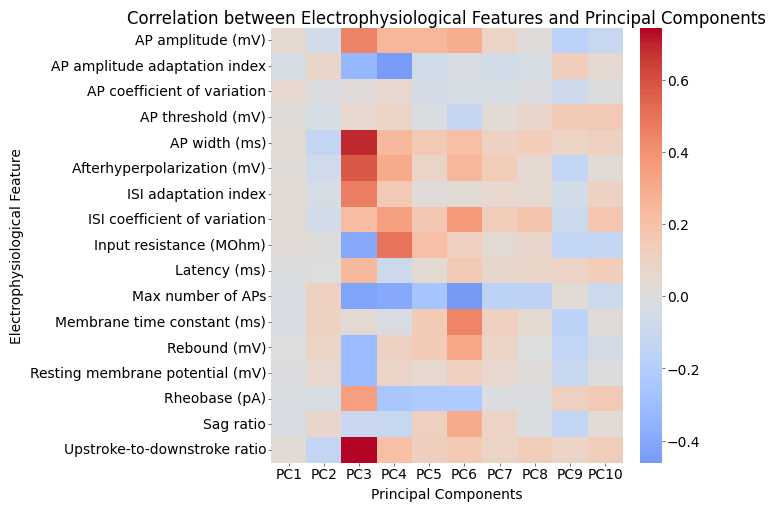

PCs with highest correlation in electrophysiological features: [0.01579773 0.09753815 2.67789968 1.13012846 0.37589762 1.08598598
 0.14954195 0.12318939 0.23376503 0.18596191]


In [49]:
from scipy.stats import pearsonr

counts = data_final[keepcells]

n_components = 10
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(counts)
loadings = np.abs(pca.components_)

combined_data = np.hstack((pcs, X))

correlations = np.zeros((X.shape[1], pcs.shape[1]))
p_values = np.zeros((X.shape[1], pcs.shape[1]))

for i in range(X.shape[1]):
    for j in range(pcs.shape[1]):
        corr, p_value = pearsonr(X[:, i], pcs[:, j])
        correlations[i, j] = corr
        p_values[i, j] = p_value
plt.figure(figsize=(7, 5))
sns.heatmap(
    correlations,
    annot=False,
    cmap="coolwarm",
    center=0,
    xticklabels=[f"PC{j+1}" for j in range(pcs.shape[1])],
    yticklabels=[ephysNames[idx] for idx in range(len(ephysNames))],
)
plt.title(
    "Correlation between Electrophysiological Features and Principal Components"
)
plt.xlabel("Principal Components")
plt.ylabel("Electrophysiological Feature")
plt.show()
print(
    f"PCs with highest correlation in electrophysiological features: {sum(correlations**2)}"
)

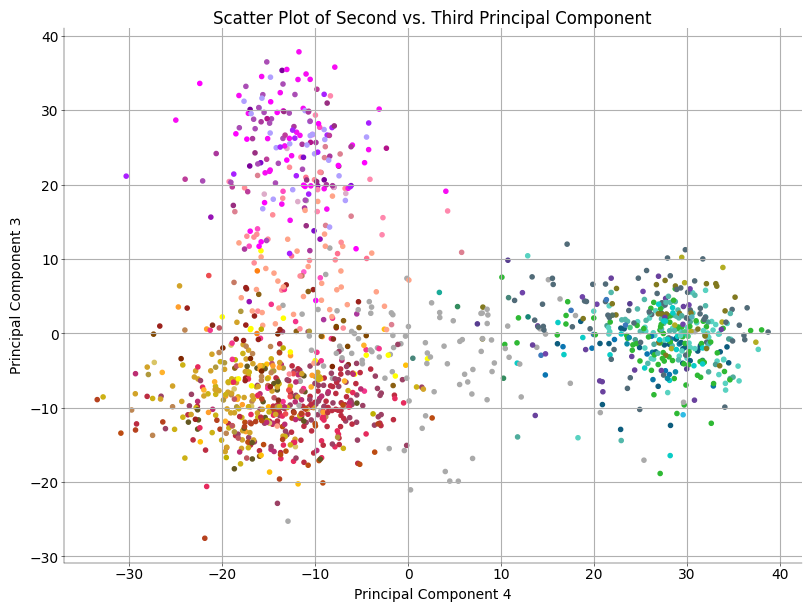

In [46]:
pc2 = pcs[:, 2]
pc3 = pcs[:, 3]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    pc2, pc3, c=cluster_colors[keepcells]
)  # Adjust alpha and s for aesthetics
plt.title("Scatter Plot of Second vs. Third Principal Component")
plt.xlabel("Principal Component 4")
plt.ylabel("Principal Component 3")
plt.grid(True)
plt.show()

C:\Users\nekur\AppData\Local\Temp\ipykernel_22956\3476536929.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


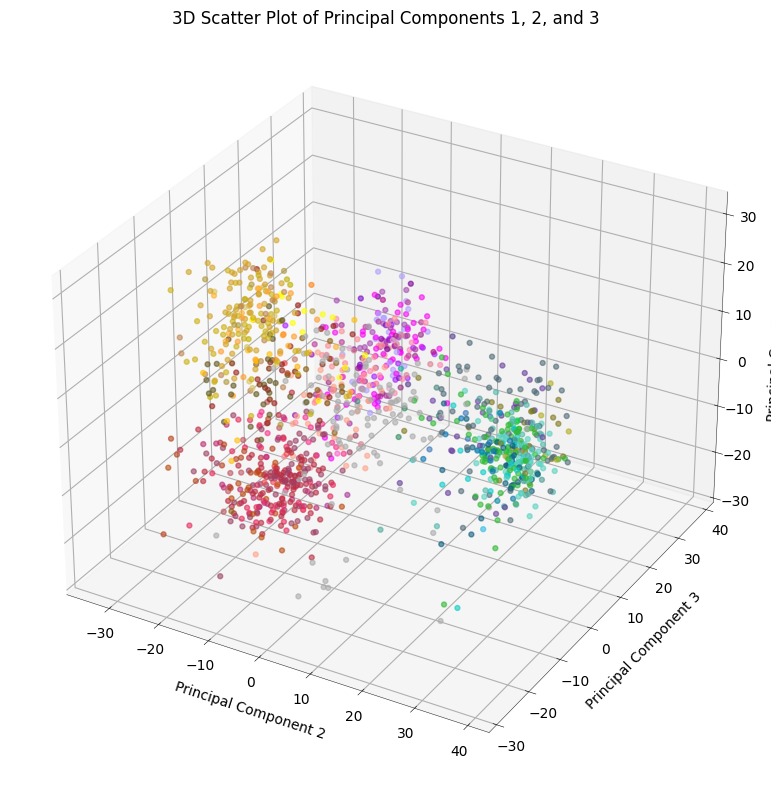

In [47]:
pc2 = pcs[:, 2]
pc3 = pcs[:, 3]
pc5 = pcs[:, 5]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(pc2, pc3, pc5, c=cluster_colors[keepcells], alpha=0.6, s=50)

# Add labels and title
ax.set_title("3D Scatter Plot of Principal Components 1, 2, and 3")
ax.set_xlabel("Principal Component 2")
ax.set_ylabel("Principal Component 3")
ax.set_zlabel("Principal Component 5")
plt.tight_layout()
plt.show()

In [68]:
# Max impact on PCs 2 and 3
genes_500 = genes[gene_var > np.sort(gene_var)[-501]]
gene_impact_idx = np.argsort(loadings, axis=1)
gene_impact_idx_pc2 = gene_impact_idx[1]
gene_impact_pc2 = genes_500[gene_impact_idx_pc2]

print("Genes with the most impact on the Principal component 2:")
for i, idx in enumerate(gene_impact_idx_pc2[:10]):
    print(f"{i+1}.{genes[idx]}")

gene_impact_idx_pc3 = gene_impact_idx[2]
gene_impact_pc3 = genes_500[gene_impact_idx_pc3]

print("Genes with the most impact on the Principal component 3:")
for i, idx in enumerate(gene_impact_idx_pc3[:10]):
    print(f"{i+1}.{genes[idx]}")

Genes with the most impact on the Principal component 2:
1.1700025D23Rik
2.1700099I09Rik
3.0610006L08Rik
4.1700021F07Rik
5.1600017P15Rik
6.1700021L23Rik
7.1700006A11Rik
8.1700008H02Rik
9.0610009E02Rik
10.1110006O24Rik
Genes with the most impact on the Principal component 3:
1.1700003M07Rik
2.1500015A07Rik
3.1700034H15Rik
4.1700011L22Rik
5.1700054M17Rik
6.1700008H02Rik
7.0610030E20Rik
8.1700025A08Rik
9.1700047G07Rik
10.1600014C10Rik


In [79]:
genes_500 = genes[gene_var > np.sort(gene_var)[-501]]
gene_impact_idx = np.argsort(loadings, axis=1)[
    :, ::-1
]  # Sorted indices by absolute loadings in descending order
loadings_norm = loadings / np.sum(loadings, axis=1, keepdims=True)

# Print top genes for PC2
print("Top 10 genes with the most impact on Principal Component 2:")
for i in range(10):
    gene = genes_500[gene_impact_idx[1][i]]
    impact = 100 * loadings_norm[1][gene_impact_idx[1][i]]
    print(f"{i+1}. {gene} (Impact: {impact:.4f} %)")

# Print top genes for PC3
print("\nTop 10 genes with the most impact on Principal Component 3:")
for i in range(10):
    gene = genes_500[gene_impact_idx[2][i]]
    impact = 100 * loadings_norm[2][gene_impact_idx[2][i]]
    print(f"{i+1}. {gene} (Impact: {impact:.4f} %)")

Top 10 genes with the most impact on Principal Component 2:
1. Gm26917 (Impact: 0.9601 %)
2. Snhg11 (Impact: 0.7065 %)
3. Kcnq1ot1 (Impact: 0.6853 %)
4. Snhg14 (Impact: 0.6846 %)
5. Adgrb3 (Impact: 0.6371 %)
6. Dlg2 (Impact: 0.6358 %)
7. Malat1 (Impact: 0.5906 %)
8. Clk1 (Impact: 0.5642 %)
9. Meg3 (Impact: 0.5452 %)
10. Gm27000 (Impact: 0.5383 %)

Top 10 genes with the most impact on Principal Component 3:
1. Gad1 (Impact: 1.6203 %)
2. Slc6a1 (Impact: 1.4406 %)
3. Gad2 (Impact: 1.3334 %)
4. Slc17a7 (Impact: 1.2721 %)
5. Arpp21 (Impact: 1.2145 %)
6. Ptk2b (Impact: 1.1954 %)
7. Rasgrp1 (Impact: 1.0309 %)
8. Nxph1 (Impact: 1.0286 %)
9. Npy (Impact: 1.0213 %)
10. Baiap2 (Impact: 1.0096 %)


In [78]:
loadings_norm = loadings / np.sum(loadings, axis=1, keepdims=True)

print(np.sum(loadings_norm[2][gene_impact_idx[2]]))

1.0000000000000002


## To Dos

- BIC oder irgendwas anderes statt silhouette score?
- NBB clustering
- PCAs zurückrechnen auf gene

- Schreiben!